In [103]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from pathlib import Path
from utils.mlflow_query import MlflowHelper
from utils.percentiles import calculate_accuracies_per_percentiles, plot_accuracies_per_percentiles
import math

In [104]:
mlflow_helper = MlflowHelper(pkl_file=None, 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441",
    tracking_uri="http://localhost:5100")
mlflow_helper.query_runs()

Querying data per run...: 100%|██████████| 4359/4359 [03:19<00:00, 21.84it/s] 


In [105]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None,
    height=5,
    aspect=1 # width = height * aspect
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge, height=height, aspect=aspect
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))


In [106]:
def count_attributes(df: pd.DataFrame, attr='data_tags_model_type'):
    return df.groupby([attr])[attr].count().sort_values(ascending=False)

# Lena's Results

In [107]:
import numpy as np
lena_df = mlflow_helper.run_df[
            (mlflow_helper.run_df["data_tags_sequence_type"] == "huawei_logs")
            & (mlflow_helper.run_df['data_tags_model_type'].isin(['causal_heuristic', 'simple', 'hierarchy', 'text']))
            & (mlflow_helper.run_df["data_params_ModelConfigrnn_type"] == "gru")
            & (mlflow_helper.run_df["data_params_SequenceConfigtest_percentage"].fillna("").astype(str) == "0.1")
            & (mlflow_helper.run_df["data_params_ModelConfigbest_model_metric"] == "val_loss")
            & (mlflow_helper.run_df["info_status"] == "FINISHED")
            & (mlflow_helper.run_df["data_params_ModelConfigrnn_dim"] == "200")
            & (mlflow_helper.run_df["data_params_ModelConfigoptimizer"].fillna("adam") == "adam")
            & (mlflow_helper.run_df["data_params_ModelConfigdropout_rate"].fillna("0.0").astype(str) == "0.5")
            & (mlflow_helper.run_df["data_params_ModelConfigrnn_dropout"].fillna("0.0").astype(str) == "0.0")
            & (mlflow_helper.run_df["data_params_ModelConfigkernel_regularizer_scope"].fillna("[]") == "[]")
            & (mlflow_helper.run_df["data_params_ExperimentConfigbatch_size"].astype(str).fillna("") == "128")
            & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
            & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
            & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
            & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("") == "0.75")
            & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
            & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
        ]
lena_df = mlflow_helper.load_best_metrics_for_ids(set(lena_df['info_run_id']))

# Categorize by timestamp
lena_df.loc[lena_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 
'data_tags_model_type'] = lena_df.loc[lena_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 
'data_tags_model_type'].apply(lambda x: x + "_with_ts")

# I've tested the heuristic with 0.02 and 0.04 min_causality
min_causalities = ['0.02', '0.04']
for min_causality in min_causalities:
    lena_df.loc[lena_df['data_params_HuaweiPreprocessorConfigmin_causality'] == min_causality, 
    'data_tags_model_type'] = lena_df.loc[lena_df['data_params_HuaweiPreprocessorConfigmin_causality'] == min_causality, 
    'data_tags_model_type'].apply(lambda x: x + f"_{min_causality}")

Querying metrics for runs: 100%|██████████| 177/177 [00:14<00:00, 11.90it/s]


In [108]:
count_attributes(lena_df)

data_tags_model_type
hierarchy                        28
text                             21
causal_heuristic_with_ts         20
simple                           20
simple_with_ts                   20
causal_heuristic_with_ts_0.04    19
causal_heuristic_0.04            11
causal_heuristic_with_ts_0.02     9
hierarchy_with_ts                 9
text_with_ts                      9
causal_heuristic_0.02             7
causal_heuristic                  4
Name: data_tags_model_type, dtype: int64

### With Timestamps

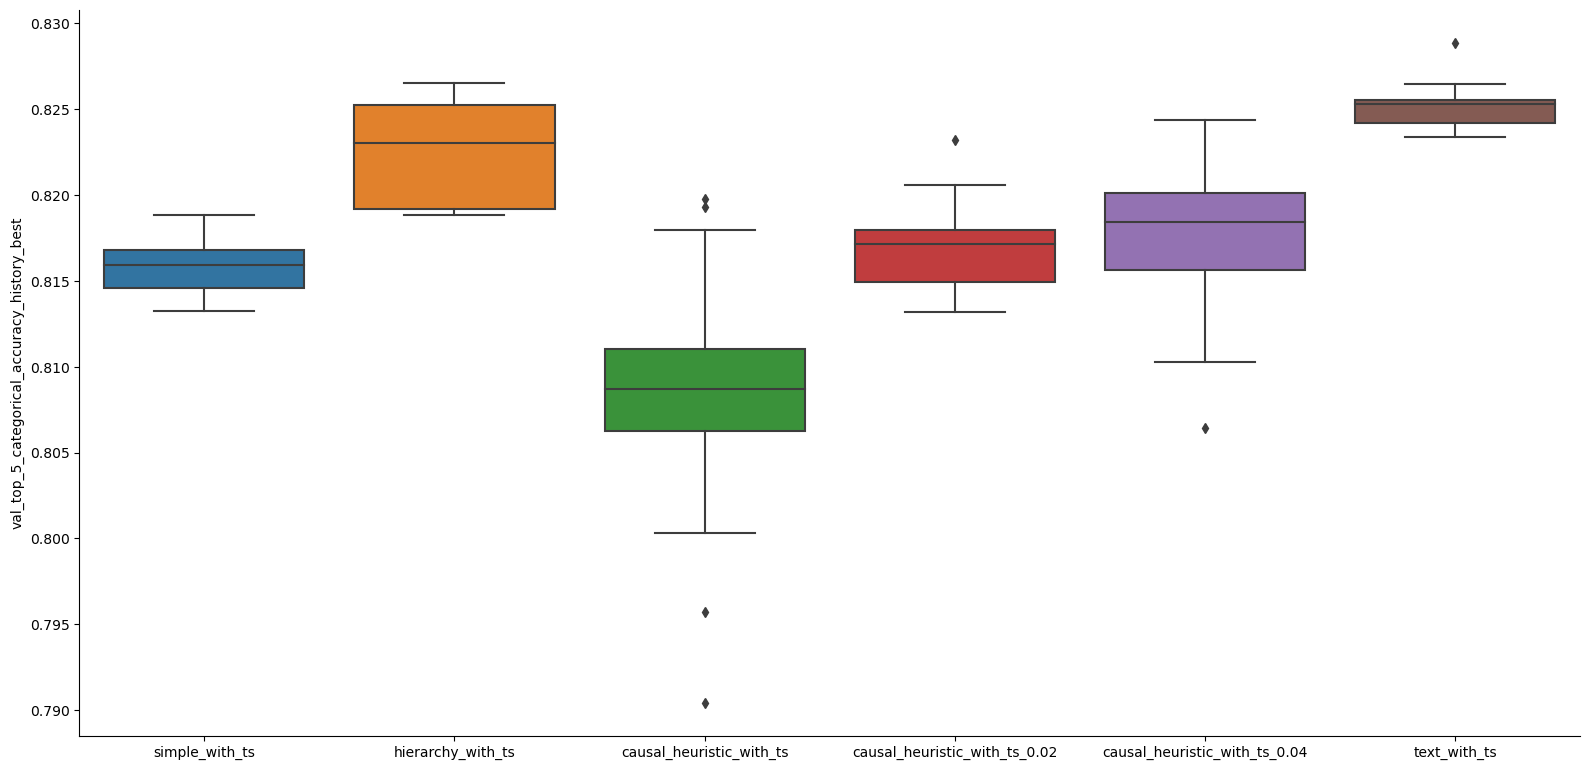

In [109]:
plot_best_metric_bar(lena_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = ['simple_with_ts', 
           'hierarchy_with_ts', 
           'causal_heuristic_with_ts', 
           'causal_heuristic_with_ts_0.02', 
           'causal_heuristic_with_ts_0.04', 
           'text_with_ts'],
height=8, aspect=2)

### Without Timestamps

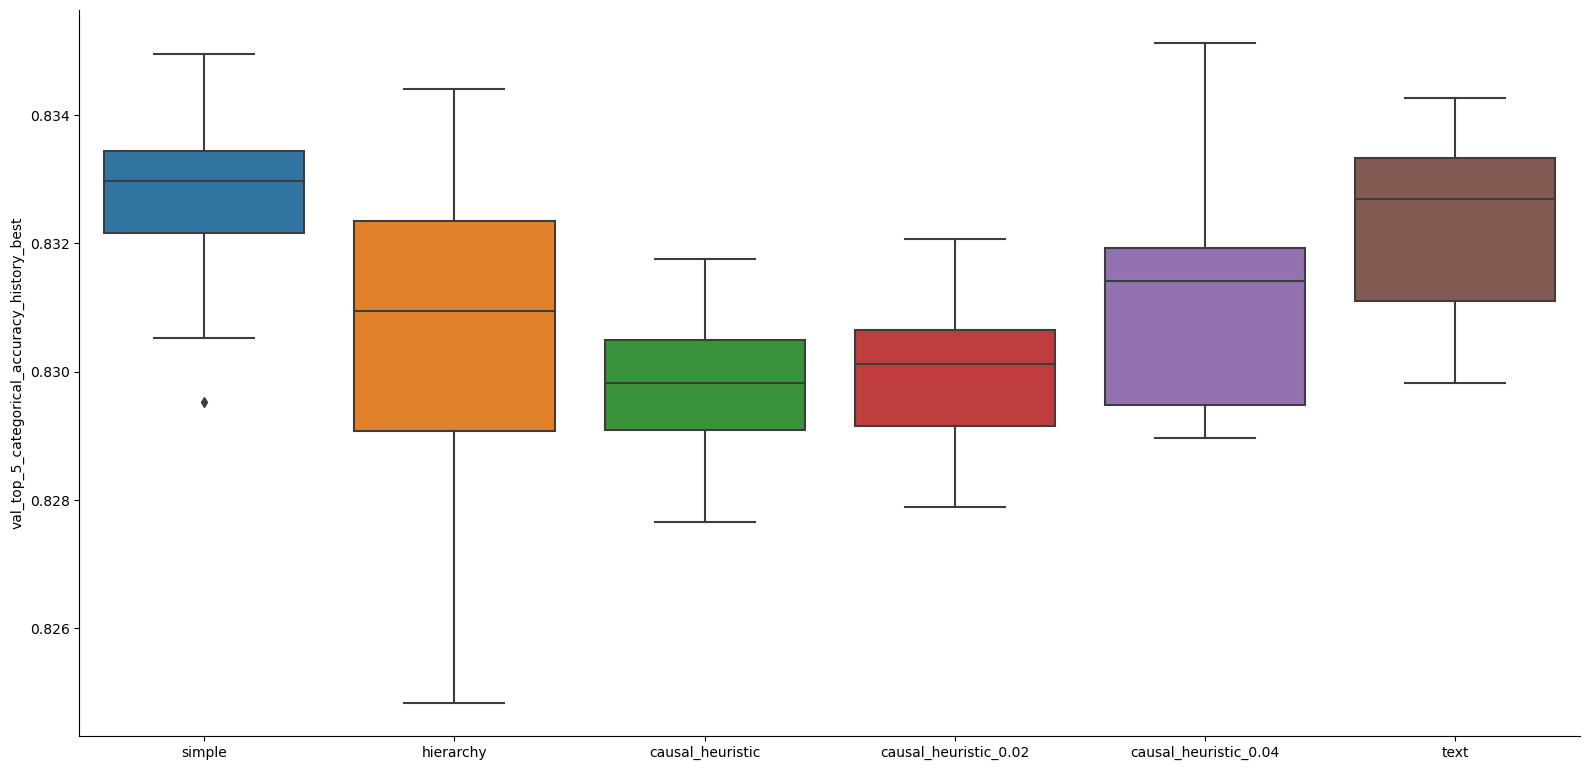

In [110]:
plot_best_metric_bar(lena_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = ['simple', 'hierarchy', 'causal_heuristic', 'causal_heuristic_0.02', 'causal_heuristic_0.04', 'text'],
height=8, aspect=2)

# Causal Algorithms' Results

In [111]:
def categorize_run_df(run_df, experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]):
    bin_configs = { # label -> (bin_size, bin_overlap)
        'small-none': (['00:00:05'], ['00:00:00']),
        'medium-none': (['0:01:00','00:00:60'], ['00:00:00']),
        'large-none': (['00:10:00'], ['00:00:00']),
        'small-small': (['00:00:05'], ['00:00:01']),
        'medium-small': (['0:01:00','00:00:60'], ['00:00:12']),
        'large-small': (['00:10:00'], ['00:02:00']),
        'small-medium': (['00:00:05'], ['00:00:03']),
        'medium-medium': (['0:01:00','00:00:60'], ['00:00:30']),
        'large-medium': (['00:10:00'], ['00:05:00']),
        'small-large': (['00:00:05'], ['00:00:04']),
        'medium-large': (['0:01:00','00:00:60'], ['00:00:48', '00:00:50']),
        'large-large': (['00:10:00'], ['00:08:00']),
    }

    matrix_df = run_df.copy()
    for algo in experimented_algos:
        for label, config in bin_configs.items():
            bin_sizes, bin_overlap = config[0], config[1]
            matrix_df.loc[(matrix_df['data_params_TimeSeriesTransformerConfigbin_size'].isin(bin_sizes)) 
            & (matrix_df['data_params_TimeSeriesTransformerConfigbin_overlap'].isin(bin_overlap))
            & (matrix_df['data_tags_model_type'] == algo), 'data_tags_model_type'] = algo + '+' + label
    
    # Categorize by timestamps
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'] = matrix_df.loc[
    matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'].apply(lambda x: x + '_with_ts')

    return matrix_df

## Template effect

In [112]:
run_df = mlflow_helper.run_df[
            (mlflow_helper.run_df["data_tags_sequence_type"] == "huawei_logs")
            & (mlflow_helper.run_df["data_params_ModelConfigrnn_type"] == "gru")
            & (mlflow_helper.run_df["data_params_SequenceConfigtest_percentage"].fillna("").astype(str) == "0.1")
            & (mlflow_helper.run_df["data_params_ModelConfigbest_model_metric"] == "val_loss")
            & (mlflow_helper.run_df["info_status"] == "FINISHED")
            & (mlflow_helper.run_df["data_params_ModelConfigrnn_dim"] == "200")
            & (mlflow_helper.run_df["data_params_ModelConfigoptimizer"].fillna("adam") == "adam")
            & (mlflow_helper.run_df["data_params_ModelConfigdropout_rate"].fillna("0.0").astype(str) == "0.5")
            & (mlflow_helper.run_df["data_params_ModelConfigrnn_dropout"].fillna("0.0").astype(str) == "0.0")
            & (mlflow_helper.run_df["data_params_ModelConfigkernel_regularizer_scope"].fillna("[]") == "[]")
            & (mlflow_helper.run_df["data_params_ExperimentConfigbatch_size"].astype(str).fillna("") == "128")
            & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
            & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
            & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
            & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("") == "0.77")
            & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
            & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
            & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigmin_causality'] == '0.01')
        ]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df['info_run_id']))

# Categorize by timestamp
matrix_df = categorize_run_df(run_df)

Querying metrics for runs: 100%|██████████| 78/78 [00:06<00:00, 12.25it/s]


In [113]:
matrix_df.groupby(['data_tags_model_type'])['data_tags_model_type'].count()

data_tags_model_type
causal_Fast-IAMB-jt+small-small            36
causal_Fast-IAMB-jt+small-small_with_ts     3
hierarchy                                   7
simple                                     20
text                                       12
Name: data_tags_model_type, dtype: int64

In [ ]:
# Sort by mean top 5 categorical accuracy
sorted_top_5_accuracy_mean_df = pd.DataFrame(
    matrix_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .mean()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_mean_df

## Performance

In [114]:
# I used different bin sizes and bin overlaps for causal_Fast-IAMB-jt, causal_Fast-IAMB-smc-cor,
# and causal_MMPC-cor
# Bins used: 5 sec (small), 60 sec (medium), 10 min (large)
# Overlaps used as percentage of bin size: 0% (none), 20% (small), 50%
# (medium), 80% (large)
# Default is medium bin, large bin overlap
experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(experimented_algos + ['simple']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df["data_params_SequenceConfigtest_percentage"].fillna("").astype(str) == "0.1")
    & (mlflow_helper.run_df["data_params_ModelConfigbest_model_metric"] == "val_loss")
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dim"] == "200")
    & (mlflow_helper.run_df["data_params_ModelConfigoptimizer"].fillna("adam") == "adam")
    & (mlflow_helper.run_df["data_params_ModelConfigdropout_rate"].fillna("0.0").astype(str) == "0.5")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dropout"].fillna("0.0").astype(str) == "0.0")
    & (mlflow_helper.run_df["data_params_ModelConfigkernel_regularizer_scope"].fillna("[]") == "[]")
    & (mlflow_helper.run_df["data_params_ExperimentConfigbatch_size"].astype(str).fillna("") == "128")
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("") == "0.75")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 446/446 [00:36<00:00, 12.29it/s]


In [115]:
matrix_df = categorize_run_df(run_df)

In [116]:
count_attributes(matrix_df)

data_tags_model_type
causal_Fast-IAMB-jt+large-medium                22
simple_with_ts                                  20
causal_Fast-IAMB-jt+medium-medium_with_ts       20
causal_Fast-IAMB-jt+small-small                 20
causal_Fast-IAMB-jt+small-medium_with_ts        20
causal_MMPC-cor+large-small                     20
causal_Fast-IAMB-smc-cor+small-small_with_ts    20
simple                                          20
causal_Fast-IAMB-jt+large-medium_with_ts        20
causal_Fast-IAMB-jt+medium-large_with_ts        19
causal_Fast-IAMB-smc-cor+small-small            19
causal_Fast-IAMB-jt+small-large_with_ts         18
causal_Fast-IAMB-jt+large-small_with_ts         18
causal_Fast-IAMB-jt+medium-none_with_ts         17
causal_Fast-IAMB-smc-cor+medium-large           17
causal_MMPC-cor+small-large                     16
causal_MMPC-cor+medium-medium                   16
causal_MMPC-cor+medium-large                    16
causal_Fast-IAMB-jt+medium-small_with_ts        16
causal_Fas

In [117]:
sorted_top_5_accuracy_median_df = pd.DataFrame(
    matrix_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .median()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_median_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small,0.833957
1,causal_Fast-IAMB-smc-cor+small-small,0.833628
2,causal_Fast-IAMB-jt+small-none,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large,0.833329
4,causal_Fast-IAMB-jt+large-medium,0.833114
5,simple,0.832964
6,causal_MMPC-cor+large-medium,0.832886
7,causal_MMPC-cor+medium-large,0.832772
8,causal_Fast-IAMB-jt+medium-medium,0.832757
9,causal_MMPC-cor+medium-medium,0.832586


In [118]:
# Sort by mean top 5 categorical accuracy
sorted_top_5_accuracy_mean_df = pd.DataFrame(
    matrix_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .mean()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_mean_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small,0.834112
1,causal_Fast-IAMB-smc-cor+small-small,0.833637
2,causal_Fast-IAMB-jt+small-none,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large,0.833210
4,causal_MMPC-cor+medium-large,0.832930
5,causal_Fast-IAMB-jt+large-medium,0.832924
6,simple,0.832727
7,causal_MMPC-cor+large-medium,0.832672
8,causal_MMPC-cor+small-large,0.832666
9,causal_Fast-IAMB-jt+medium-medium,0.832652


In [119]:
k = 3
# Without timestamps
top_k_mean_no_ts = sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()[:k]
top_k_median_no_ts = sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()[:k]

if "simple" not in top_k_mean_no_ts:
    top_k_mean_no_ts.append('simple')

if "simple" not in top_k_median_no_ts:
    top_k_median_no_ts.append('simple')

# With timestamps
top_k_mean_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()))[:k]
top_k_median_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()))[:k]

if "simple_with_ts" not in top_k_mean_ts:
    top_k_mean_ts.append('simple_with_ts')

if "simple_with_ts" not in top_k_median_ts:
    top_k_median_ts.append('simple_with_ts')

### With Timestamps

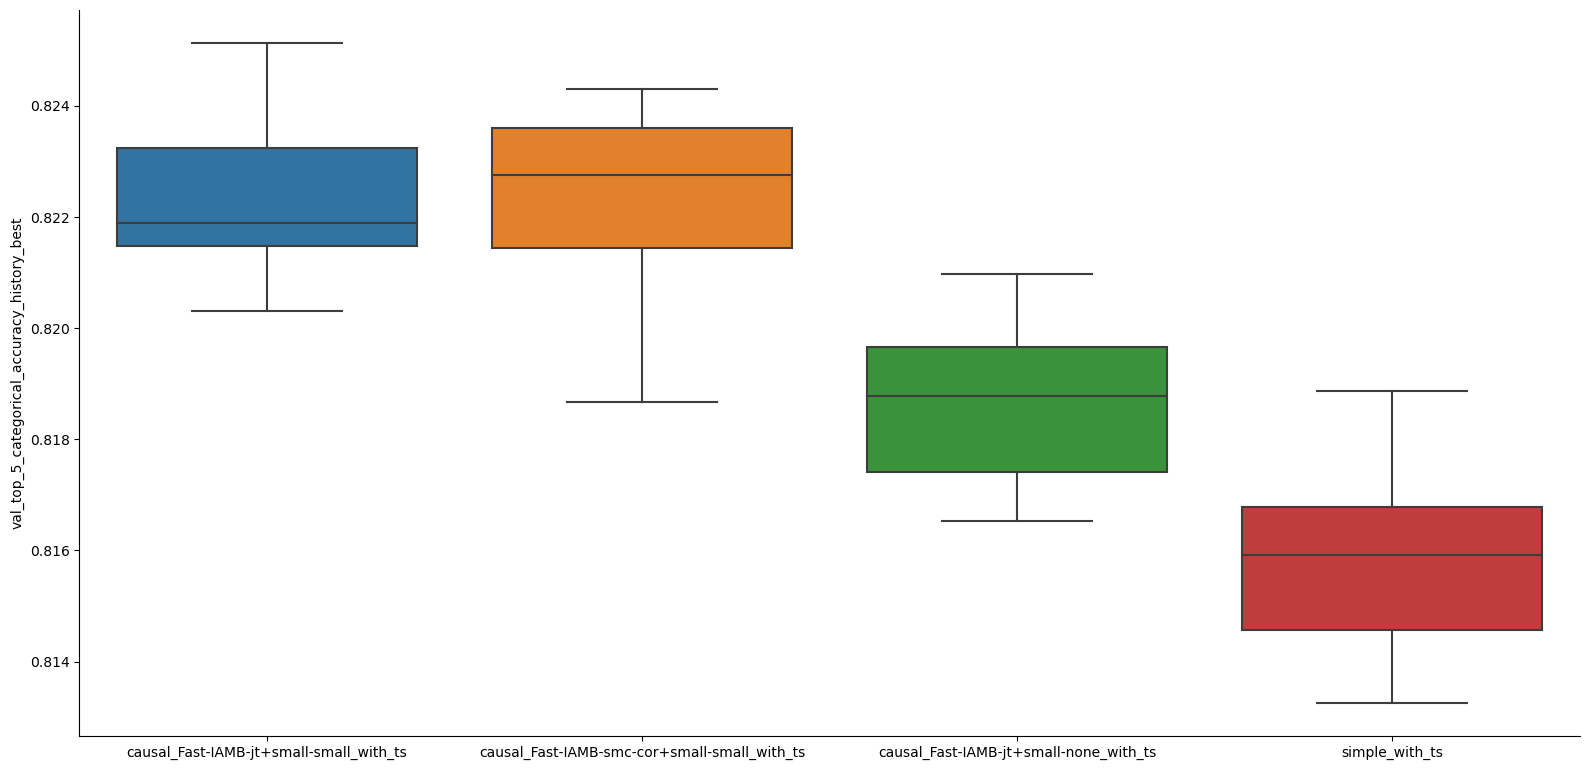

In [120]:
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_ts,
height=8,
aspect=2)

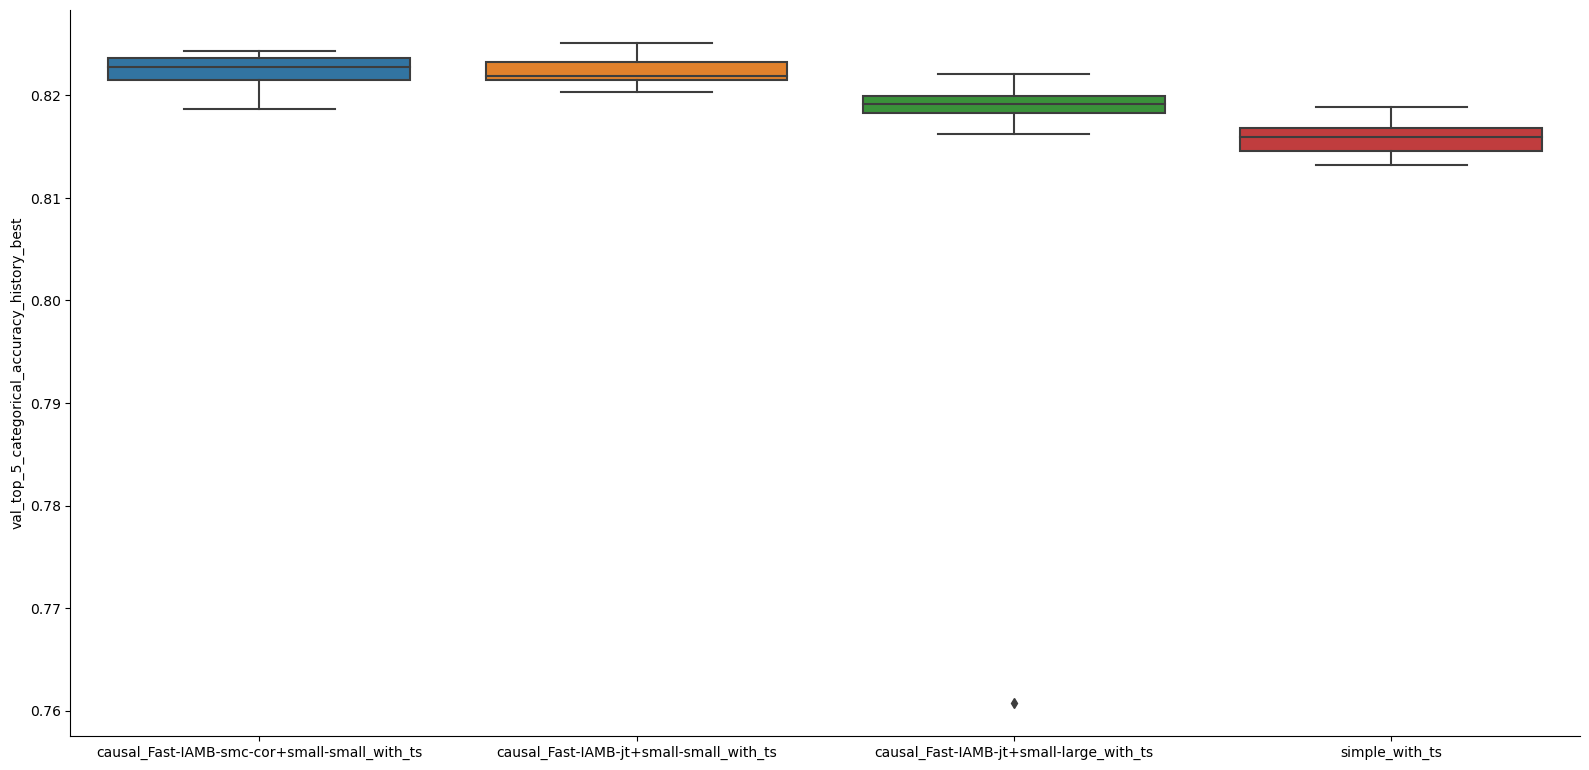

In [121]:
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_median_ts,
height=8,
aspect=2)

### Without Timestamps

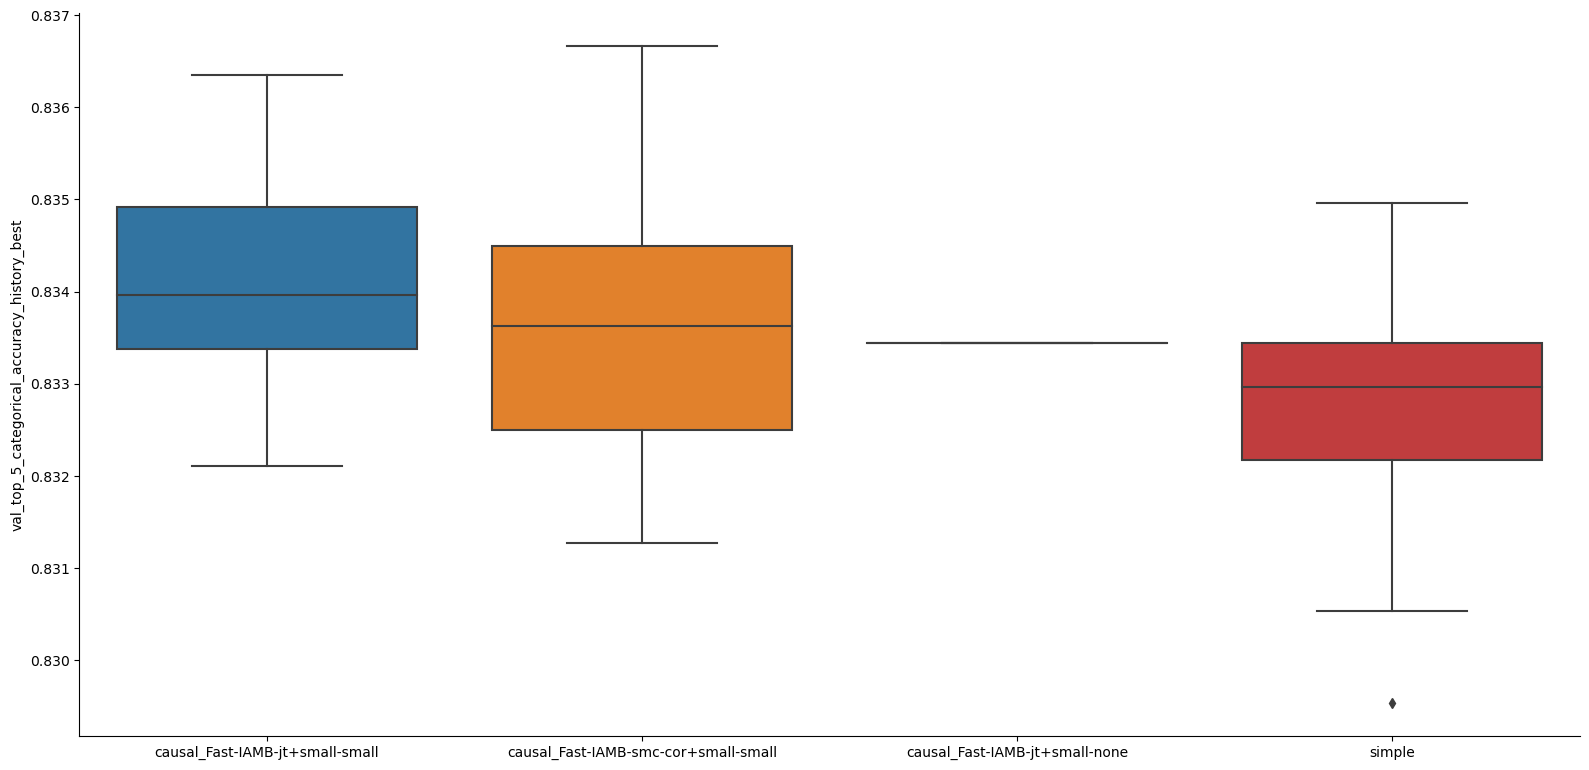

In [122]:
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_no_ts,
height=8,
aspect=2)

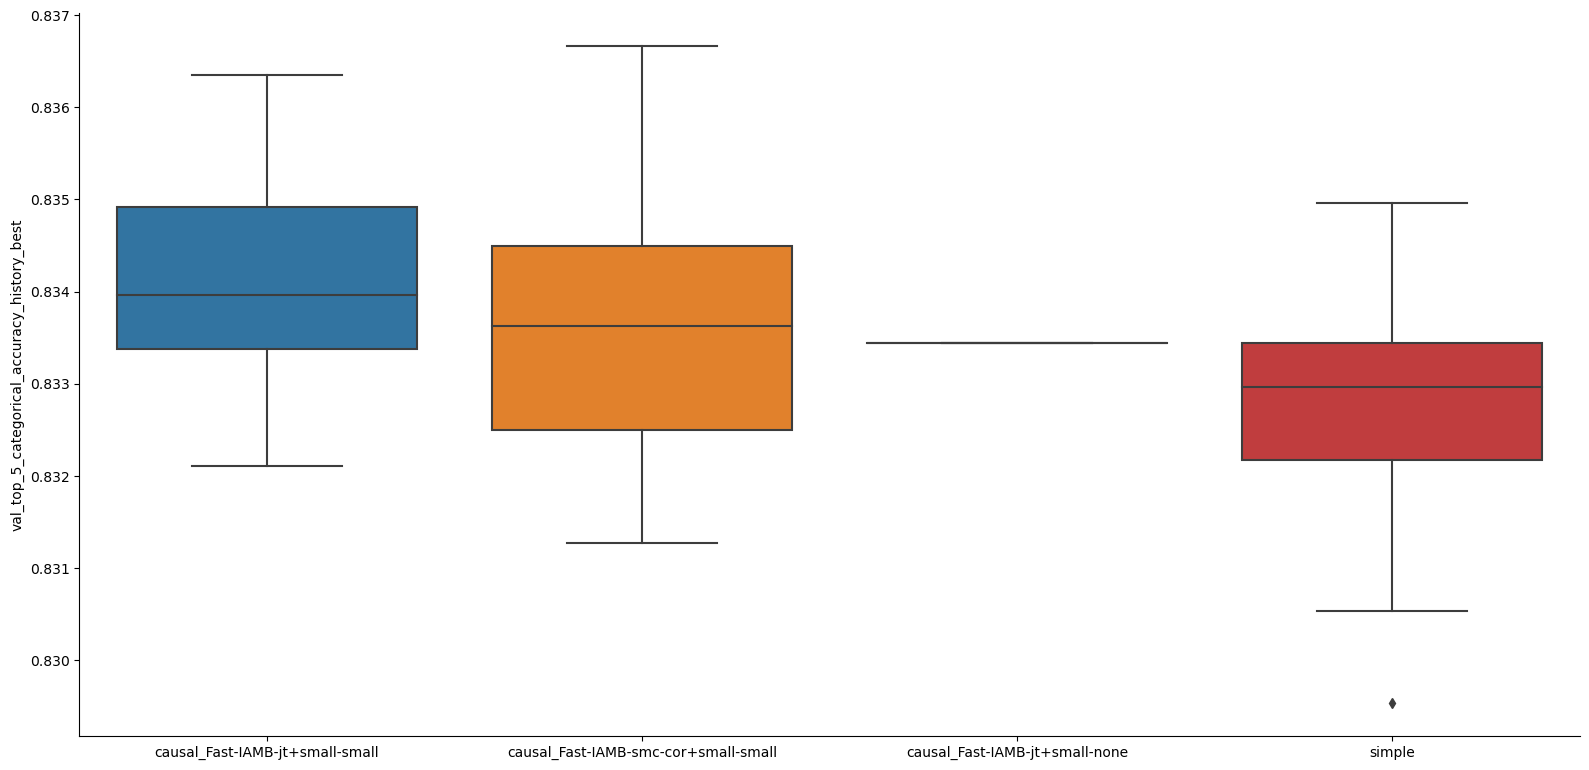

In [123]:
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_median_no_ts,
height=8,
aspect=2)

### Causal Algorithm vs Other DL Types (With Timestamps)

In [124]:
test_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df["data_params_SequenceConfigtest_percentage"].fillna("").astype(str) == "0.1")
    & (mlflow_helper.run_df["data_params_ModelConfigbest_model_metric"] == "val_loss")
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dim"] == "200")
    & (mlflow_helper.run_df["data_params_ModelConfigoptimizer"].fillna("adam") == "adam")
    & (mlflow_helper.run_df["data_params_ModelConfigdropout_rate"].fillna("0.0").astype(str) == "0.5")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dropout"].fillna("0.0").astype(str) == "0.0")
    & (mlflow_helper.run_df["data_params_ModelConfigkernel_regularizer_scope"].fillna("[]") == "[]")
    & (mlflow_helper.run_df["data_params_ExperimentConfigbatch_size"].astype(str).fillna("") == "128")
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("") == "0.75")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigmin_causality'] == '0.01')
]
test_df = mlflow_helper.load_best_metrics_for_ids(set(test_df["info_run_id"]))
test_matrix_df = categorize_run_df(test_df)
count_attributes(test_matrix_df)

Querying metrics for runs: 100%|██████████| 497/497 [00:40<00:00, 12.34it/s]


data_tags_model_type
hierarchy                                       28
causal_Fast-IAMB-jt+large-medium                22
text                                            21
causal_MMPC-cor+large-small                     20
causal_heuristic_with_ts                        20
causal_Fast-IAMB-jt+large-medium_with_ts        20
causal_Fast-IAMB-smc-cor+small-small_with_ts    20
causal_Fast-IAMB-jt+medium-medium_with_ts       20
causal_Fast-IAMB-jt+small-small                 20
causal_Fast-IAMB-jt+small-medium_with_ts        20
causal_Fast-IAMB-jt+medium-large_with_ts        19
causal_Fast-IAMB-smc-cor+small-small            19
causal_Fast-IAMB-jt+small-large_with_ts         18
causal_Fast-IAMB-jt+large-small_with_ts         18
causal_Fast-IAMB-smc-cor+medium-large           17
causal_Fast-IAMB-jt+medium-none_with_ts         17
causal_MMPC-cor+small-large                     16
causal_MMPC-cor+medium-large                    16
causal_Fast-IAMB-jt+medium-small_with_ts        16
causal_MMP

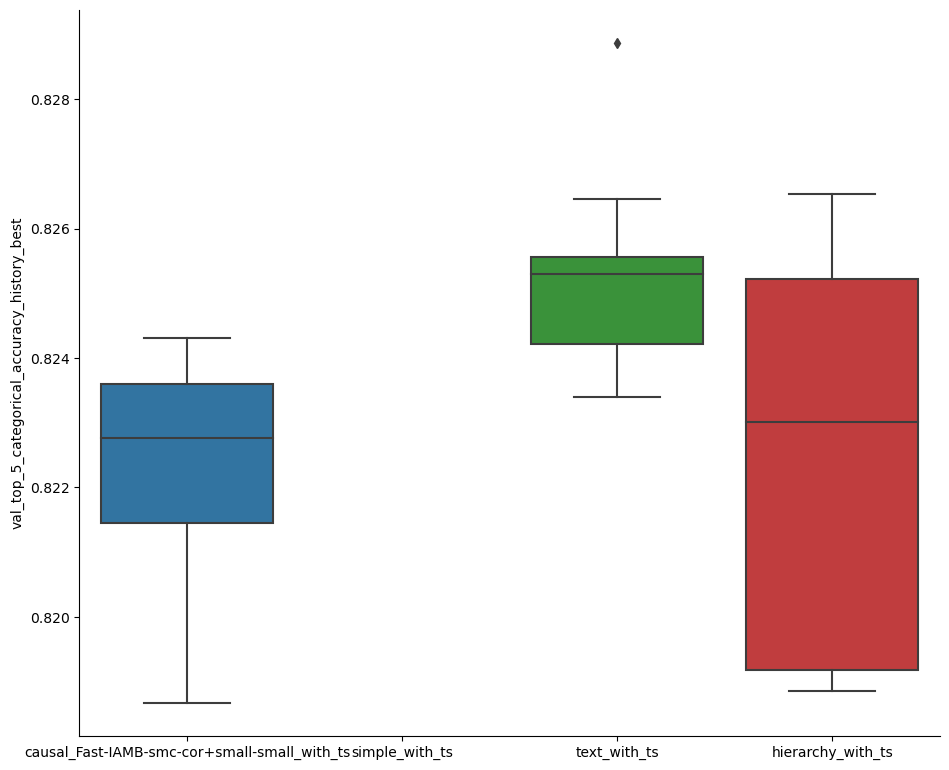

In [125]:
plot_best_metric_bar(test_matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = ['causal_Fast-IAMB-smc-cor+small-small_with_ts', 'simple_with_ts', 'text_with_ts', 'hierarchy_with_ts'],
height=8,
aspect=1.2)

## Graph Densities

In [126]:
knowledge_path = Path('/home/i40/almasrirz/Domain-Guided-Monitoring/data/knowledge_original')
pathlist = knowledge_path.glob('**/*.csv')
dataframes_with_ts = {} # type -> df
dataframes_without_ts = {}
for path in pathlist:
    knowledge_type = path.name.split('_knowledge')[0]
    if 'with_ts' in knowledge_type:
        dataframes_with_ts[knowledge_type] = pd.read_csv(path)
    else:
        dataframes_without_ts[knowledge_type] = pd.read_csv(path)

In [127]:
from src.features import knowledge
import json

def fetch_statistics(dataframes, remove_dates):

    if remove_dates:
        with open('/home/i40/almasrirz/Domain-Guided-Monitoring/data/x_vocab_without_ts.json', 'r') as f:
            metadata = json.load(f)
    else:
        with open('/home/i40/almasrirz/Domain-Guided-Monitoring/data/x_vocab_with_ts.json', 'r') as f:
            metadata = json.load(f)

    statistics_records = []
    for name, df in dataframes.items():
        k = None
        if name.startswith('causal'):
            k = knowledge.CausalityKnowledge(knowledge.KnowledgeConfig())
            k.build_causality_from_df(df, metadata)
        elif name.startswith('hierarchy'):
            k = knowledge.HierarchyKnowledge(knowledge.KnowledgeConfig())
            k.build_hierarchy_from_df(df, metadata)
        else:
            k = knowledge.DescriptionKnowledge(knowledge.KnowledgeConfig())
            k.build_knowledge_from_df(df, metadata)
        v_in = len(k.vocab)
        v_g = len(k.extended_vocab)
        v_hidden = v_g - v_in
        edges = set()
        for i in range(len(k.vocab)):
            connections = k.get_connections_for_idx(i)
            for connection in connections:
                edges.add((i, connection))
        statistics_records.append({
            'Model': name,
            'V_G': v_g,
            'V_in': v_in,
            'V_hidden': v_hidden,
            'E_G': len(edges)
        })
    return pd.DataFrame.from_records(statistics_records).set_index('Model')

In [128]:
statistics_with_ts = fetch_statistics(dataframes_with_ts, remove_dates=False)

Building Causality from df: 1961it [00:00, 30551.56it/s]
Building Causality from df: 923it [00:00, 33981.20it/s]
Building Hierarchy from df: 6957it [00:00, 31358.67it/s]
Building Causality from df: 674it [00:00, 35085.27it/s]
Building Causality from df: 780it [00:00, 25439.59it/s]
Building Causality from df: 926it [00:00, 23373.91it/s]
Building Causality from df: 24192it [00:00, 31781.27it/s]
Building Causality from df: 316it [00:00, 28766.77it/s]
Building Causality from df: 37607it [00:01, 30549.24it/s]
Building Causality from df: 536it [00:00, 21448.92it/s]
Building Causality from df: 858it [00:00, 27877.33it/s]
Building Causality from df: 14954it [00:00, 31454.40it/s]
Building Causality from df: 926it [00:00, 27445.33it/s]
Building Causality from df: 342it [00:00, 21544.14it/s]
Building Causality from df: 665it [00:00, 35948.09it/s]
Building Causality from df: 666it [00:00, 28744.37it/s]
Building Causality from df: 284it [00:00, 31403.93it/s]
Building Causality from df: 490it [00:00

In [129]:
statistics_without_ts = fetch_statistics(dataframes_without_ts, remove_dates=True)

Building Causality from df: 268it [00:00, 29935.38it/s]
Building Causality from df: 358it [00:00, 31538.11it/s]
Building Causality from df: 452it [00:00, 31852.44it/s]
Building Causality from df: 520it [00:00, 25890.46it/s]
Building Causality from df: 376it [00:00, 35123.79it/s]
Building Causality from df: 506it [00:00, 22647.48it/s]
Building Causality from df: 641it [00:00, 32413.63it/s]
Building Causality from df: 324it [00:00, 36948.19it/s]
Building Causality from df: 1776it [00:00, 32872.69it/s]
Building Causality from df: 496it [00:00, 29252.44it/s]
Building Causality from df: 25719it [00:00, 31630.11it/s]
Building Causality from df: 408it [00:00, 27975.74it/s]
Building Causality from df: 565it [00:00, 30542.75it/s]
Building Causality from df: 358it [00:00, 34683.69it/s]
Building Causality from df: 276it [00:00, 20896.94it/s]
Building Causality from df: 572it [00:00, 27005.20it/s]
Preprocessing description words: 100%|██████████| 1559/1559 [00:00<00:00, 18392.14it/s]
Building Caus

In [130]:
statistics_with_ts

,V_G,V_in,V_hidden,E_G
Model,,,,
causal_Fast-IAMB-jt_with_ts_more_templates_small_small,1810,1446,364,2010
causal_Fast-IAMB-smc-cor_with_ts_small_small,1653,1446,207,2166
hierarchy_with_ts,1968,1446,522,24817
causal_Fast-IAMB-jt_with_ts_medium_medium,1586,1446,140,1916
causal_Fast-IAMB-jt_with_ts_medium_large,1627,1446,181,2002
causal_Fast-IAMB-jt_with_ts_small_none,1666,1446,220,2163
causal_heuristic_with_ts_0.02_min_causality,2098,1446,652,22161
causal_Fast-IAMB-jt_with_ts_large_small,1539,1446,93,1633
causal_heuristic_with_ts,2104,1446,658,35835


In [131]:
statistics_without_ts

,V_G,V_in,V_hidden,E_G
Model,,,,
causal_Fast-IAMB-smc-cor_without_ts_large_small,968,865,103,992
causal_Fast-IAMB-jt_without_ts_medium_none,1002,865,137,1032
causal_MMPC-cor_without_ts_medium_none,1047,865,182,1093
causal_Fast-IAMB-jt_without_ts_more_edges,1076,865,211,1119
causal_MMPC-cor_without_ts_large_large,1000,865,135,1058
causal_Fast-IAMB-jt_without_ts_medium_large,1071,865,206,1114
causal_Fast-IAMB-jt_without_ts_small_large,1146,865,281,1178
causal_Fast-IAMB-jt_without_ts_large_large,987,865,122,1025
causal_Fast-IAMB-jt_without_ts_more_nodes_small_small,1086,865,221,1115
